In [1]:
library("MASS")
library("car")
library('ggplot2')
library('gridExtra')
library('tidyr')
library('repr')
data = read.csv("BodyFat.csv", header = TRUE)[,-1]
attach(data)

## 1. Introduction

Based on a dataset consisting of Percentage of Body Fat and other 14 physical measurements of 252 men, we aimed at proposing a simple linear model to predict men's Body Fat using some clinical measurements.

To achieve this goal, we used several criterions, including BIC, AIC, Mallow's Cp, to select important variables. After model diagonstics, we transformed independent variables to better satisfy linear model assumptions.

We found out that among all 14 variables, the linear function of WEIGHT, WEIGHT transformation, ABDOMEN, FOREARM, and WRIST can best interpret bodyfat.

## 2.  Data Cleaning

### 2.1 Exploratory Data Analysis

We first took a look at raw data to detect strange records.

Here is the boxplots for variable `BODYFAT` and `HEIGHT`.

In [ ]:
options(repr.plot.width=3, repr.plot.height=2.5, repr.fig.align='center')
g = ggplot(data, mapping = aes('',BODYFAT))
p1 <- g + geom_boxplot(fill = "lightblue3", alpha = 0.8) + xlab('') + ylab('') + ggtitle('Boxplot for BODYFAT') +
    theme(text = element_text(size = 7), element_line(size = 0.1), plot.title = element_text(hjust = 0.5))
g = ggplot(data, mapping = aes('',HEIGHT))
p2 <- g + geom_boxplot(fill = "lightblue3", alpha = 0.8) + xlab('') + ylab('') + ggtitle('Boxplot for HEIGHT') +
    theme(text = element_text(size = 7), element_line(size = 0.1), plot.title = element_text(hjust = 0.5))
grid.arrange(p1, p2, ncol=2)
detach(data)
data <- data[c(-182, -42),]
attach(data)

**Form the Boxplot for BODYFAT, we can clearly see that there are two suspicious records:**
* the one with extremly large `BODYFAT`: After evaluating his other measurements, we concluded that his bodyfat value was reasonable and kept the record.
* the one with zero `BODYFAT`: It is impossible for a human to have $0%$ body fat. We tried to remedy this record by calculating `BODYFAT` using `DENSITY` based on Siri's equation, however, the calculated value was $-3.61$ which is even more ridiculous. As a result, we decided to exclude this record.

**From the Boxplot for HEIGHT, we can detect one abonormal record:**
* the one with extremly small `HEIGHT`: We found out that although this man is extremly short, his `WEIGHT` seems normal as well as all of the other measurements, which means that this man is not disabled or has some illness. Thus, we concluded that this record is not correct and excluded it.

After excluding record No.182 (the zero body fat one) and record No.42 (the extremly short one), we explored the general trend of `BODYFAT` versus all other measurements. As the plot shown below indicated, all measurments except `HEIGHT` seems to have a positive influence on `BODYFAT` when other variables are fixed.

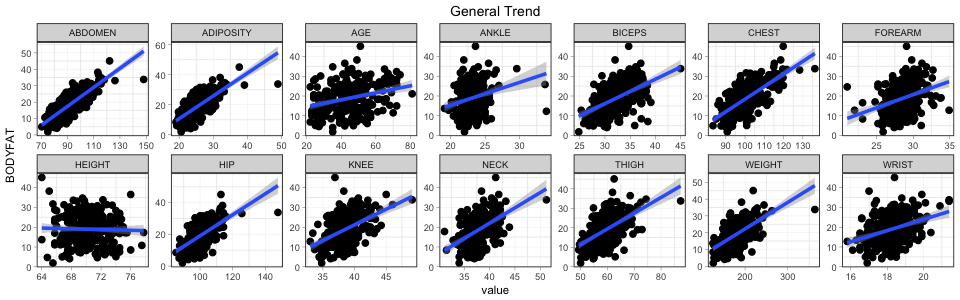

In [3]:
options(repr.plot.width=8, repr.plot.height=2.5, repr.fig.align='center')
subdata <- data[, -2]
subdata %>%
  gather(-BODYFAT, key = "var", value = "value") %>%
  ggplot(aes(x = value, y = BODYFAT)) +
  geom_point() + geom_smooth(method = 'lm') +
  ggtitle('General Trend') + 
  facet_wrap(~ var, scales = "free", ncol = 7) +
  theme_bw(base_size = 7) +
  theme(text = element_text(size = 7), element_line(size = 0.1), plot.title = element_text(hjust = 0.5))

### 2.2 Consistence of BODYFAT versus DENSITY

According to our background, `BODYFAT` and `DENSITY` should satisfy Siri's equation when they're both correct. If not, we can conclude at least one of them is wrong.

To check this point, we first fitted a linear model denoted as $model \ 0$ in form of:
$$ BODYFAT = \beta_{0} + \beta_{1} \frac{1}{DENSITY}$$
Since all valid record should fit this linear model quite well, we suspected the outliers may contain mistake.
Here is the residual plot for $model \ 0$:

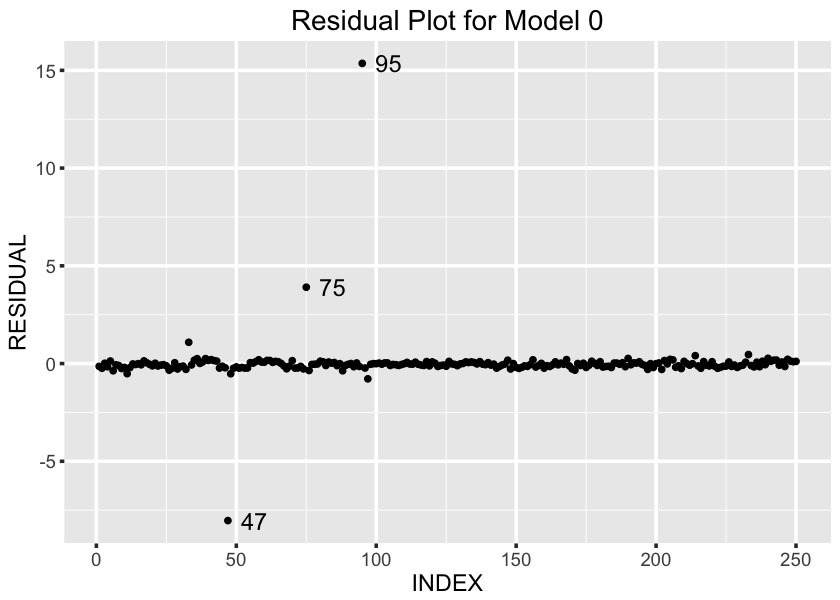

In [6]:
options(repr.plot.width=7, repr.plot.height=5, repr.fig.align='center')
reverse_de <- 1/DENSITY
m0 <- lm(BODYFAT ~ reverse_de)
residual <- m0$residuals
d <- data.frame(cbind(index = seq(length(residual)), residual))
ggplot(d, aes(index,residual, label = index)) +
    geom_point() +
    ggtitle('Residual Plot for Model 0') +
    xlab('INDEX') +
    ylab('RESIDUAL') +
    theme(text = element_text(size = 14), element_line(size = 1), plot.title = element_text(hjust = 0.5))+ 
    geom_text(aes(label = ifelse(abs(residual) > 2, as.character(index),''), hjust = -0.5, vjust = 0.5), size = 5)

**From the residual plot above, we can clearly see that there are three records have relatively large residuals, which indicate abnormaity. **

**We futher evaluated those three records in detail:**
* **record No.95:** We first calculated `BODYFAT` through `DENSITY`, the calculated body fat value was about 0.4, which is exteremly small. We then compared other measurements of this man with other individual's measurements and found out this man was quite normal. Thus, it is most likely that `DENSITY` record was wrong and we kept the record `BODYFAT` value.
* **record No.75:** The calculated `BODYFAT` for him was about 14.1. We compared him with record No.24, since No.24 has very similar `HEIGHT` and `WEIGHT` compared to No.76 (The partial measurements of these two records is shown below). All measurements of these two men are similar enough except `AGE`, we thought older people tend to have larger body fat percentage (also indicated by Fig. General Trend), and the calculated `BODYFAT` is smaller than that of No.24. We concluded the original `BODYFAT` value was more reasonable.


In [33]:
data[c(75,24),-c(2,6)]

,BODYFAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
76,18.3,61,148.25,67.5,36.0,91.6,81.8,94.8,54.5,37.0,21.4,29.3,27.0,18.3
24,17.6,32,148.75,70.0,35.5,86.7,80.0,93.4,54.9,36.2,22.1,29.8,26.7,17.1


* record No.47: The calculated `BODYFAT` for him was about 14.1. We compared him with record No.24, since No.24 has very similar `HEIGHT` and `WEIGHT` compared to No.48 (The partial measurements of these two records is shown below). Most of their measurements are similar except No.48's `CHEST` is about 3 cm larger, we thought this is not a very huge difference and won't result in a big difference between two men's `BODYFAT`. Thus, the original `BODYFAT` seems too small and we replaced it with the calculated one.

In [34]:
data[c(47,24),-c(2,6)]

,BODYFAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
48,6.4,39,148.50,71.25,34.6,89.8,79.5,92.7,52.7,37.5,21.9,28.8,26.8,17.9
24,17.6,32,148.75,70.00,35.5,86.7,80.0,93.4,54.9,36.2,22.1,29.8,26.7,17.1


### 2.3 Consistence of BMI versus HEIGHT and WEIGHT

In this part, we checked the consistence of BMI versus `HEIGHT` and `WEIGHT` based on a standard formula:
$$ BMI = \frac{weight (kg)} {height (m)^{2}} $$
We calculated BMI (written as `ADIPOSITY` in data set) useing the formula above. If one record is correct, the recorded `ADIPOSITY` should be close enough to calculate one. 

In [35]:
options(repr.plot.width=7, repr.plot.height=6.5, repr.fig.align='center')
data$WEIGHT <- data$WEIGHT * 0.453592
data$HEIGHT <- data$HEIGHT * 0.0254
detach(data)
attach(data)

The following objects are masked from data (pos = 3):

    ABDOMEN, ADIPOSITY, AGE, ANKLE, BICEPS, BODYFAT, CHEST, DENSITY,
    FOREARM, HEIGHT, HIP, KNEE, NECK, THIGH, WEIGHT, WRIST

The following objects are masked from data (pos = 4):

    ABDOMEN, ADIPOSITY, AGE, ANKLE, BICEPS, BODYFAT, CHEST, FOREARM,
    HEIGHT, HIP, KNEE, NECK, THIGH, WEIGHT, WRIST



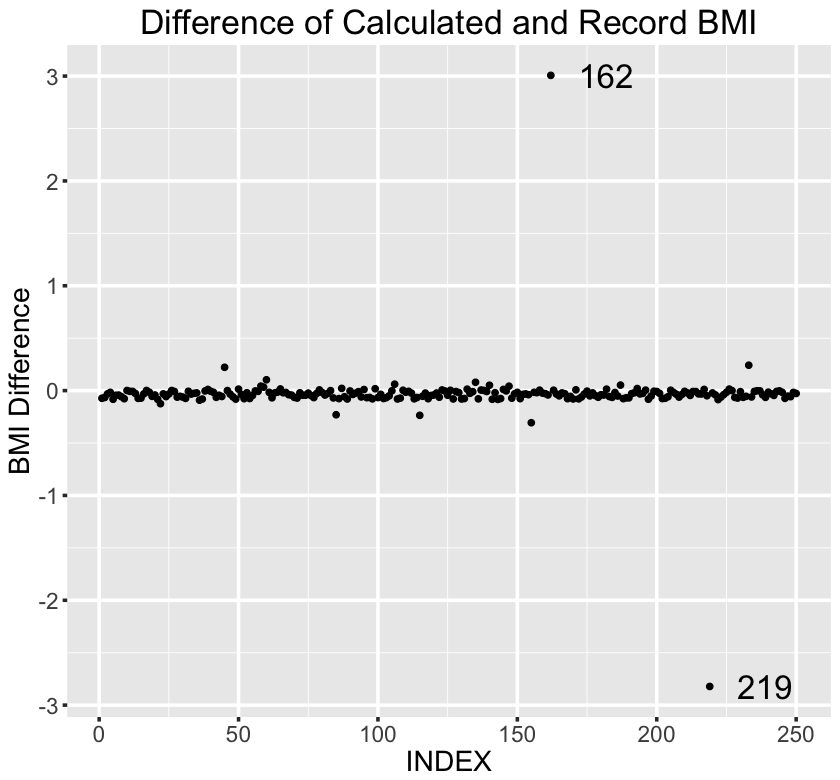

In [36]:
BMI <- WEIGHT/(HEIGHT^2)
diff <- BMI - ADIPOSITY
d <- data.frame(cbind(index = seq(length(residual)), diff))
ggplot(d, aes(index,diff, label = index)) +
    geom_point() +
    ggtitle('Difference of Calculated and Record BMI') +
    xlab('INDEX') +
    ylab('BMI Difference') +
    theme(text = element_text(size = 17), element_line(size = 1), plot.title = element_text(hjust = 0.5))+ 
    geom_text(aes(label = ifelse(abs(diff) > 2, as.character(index),''), hjust = -0.5, vjust = 0.5), size = 7)

**From the Difference plot above, there are two abnormal points: No.162, No.219, we examined them individually:**
* **record No.162:** We compare it with record No.19 since they have similar `HEIGHT` and `WEIGHT`. Look the measurments in detail as shown below, we found out that No.19 man has stronger chest, smaller Abdomen circumference and larger biceps circumference. All of these indicate a smaller bodyfat which is not the case. So we thought these two people don’t have similar `HEIGHT` and `WEIGHT`. Thus, the obs 163 may not be valid.

In [37]:
data[c(162, 19),-c(2,6)]

,BODYFAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
163,13.3,33,83.57433,1.74625,40.7,98.9,92.1,103.5,64.0,37.3,23.5,33.5,30.6,19.7
19,16.1,28,83.34753,1.72085,38.0,106.8,89.6,102.4,64.2,38.7,22.9,37.2,30.5,18.5


* **record No.219:** We compared No.219 with No.218 and observed No.221 is lighter and heigher with smaller `BODYFAT`, larger `WRIST` and `ANKLE` value. This means that the No.218 guy has less fat and larger bone, so he should look much thinner than No.219 man. HOWEVER, most measurements of No.218 man is larger than No.218 man, which makes no sense. We conclude that there is something wrong with `HEIGHT` or `WEIGHT` value for No.219 record and excluded this record.

In [38]:
data[c(219, 218),-c(2,6)]

,BODYFAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
221,12.7,54,69.51297,1.79070,38.5,99.0,91.8,96.2,57.7,38.1,23.9,31.4,29.9,18.9
220,15.1,53,70.07996,1.75895,37.6,93.9,88.7,94.5,53.7,36.2,22.0,28.5,25.7,17.1


In [39]:
detach(data)
data <- data[-c(162, 219),-2]
attach(data)

The following objects are masked from data (pos = 3):

    ABDOMEN, ADIPOSITY, AGE, ANKLE, BICEPS, BODYFAT, CHEST, FOREARM,
    HEIGHT, HIP, KNEE, NECK, THIGH, WEIGHT, WRIST

The following objects are masked from data (pos = 4):

    ABDOMEN, ADIPOSITY, AGE, ANKLE, BICEPS, BODYFAT, CHEST, FOREARM,
    HEIGHT, HIP, KNEE, NECK, THIGH, WEIGHT, WRIST



## 3. Variable Selection

In order to fit a correct, accurate and simple model, we did variable selection using various criterion. The following table displays the number of selected variables and their corresponding methods.
Here is the number of selected variables and their corresponding methods.

| Method               | Selected Varibles               |
| :--------------------| :-----------------------------: | 
| BIC Backward         | WEIGHT, ABDOMEN, FOREARM, WRIST |
| BIC  Forward  & Both | ABDOMEN, WEIGHT                 |
| AIC Backward         | 10 variables                    | 
| AICForward  & Both   | 6 variables                     | 
| Mallow's Cp          | 9 variables                     |
| LASSO                | 5 variables                     |
| rpart                | 5 variables                     |

To furthur evaluate the selected models, we applied anova on full model versus all of the selected ones. 

It turns out that the four variables model (denote as $model1$) is good enough and has no significant difference between full model. Here is the anova result for $model1$ versus $Full \ model$:

We also keeped the two variables model for futher imporvement.


In [40]:
m_full <- lm(BODYFAT ~., data)
m1 <- lm(BODYFAT ~ WEIGHT + FOREARM + ABDOMEN + WRIST) 
m2 <- lm(BODYFAT ~ WEIGHT + ABDOMEN)

In [41]:
anova(m_full, m1)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
233,3608.018,NA,NA,NA,NA
243,3855.735,-10,-247.7172,1.599718,0.1074755


We can see that p-value for this test is $0.107$, larger than threshold $0.05$ which means that we can retain the null hypothesis to say there is no significant difference between $Full \  model$ and $model\ 1$. It means that $model\ 1$ is good enough.

We also conducted ANOVA for two variables model (denote as $model 2$) versus $Full model$. The result is shown below:

In [42]:
anova(m_full, m2)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
233,3608.018,NA,NA,NA,NA
245,4068.969,-12,-460.9506,2.48062,0.004506384


The p-value is about $0.0045$ which means we can reject null hypothesis and there exists significant difference between $model \ 2$ and $Full \ model$.
Since the main goal for this project is to develop a **simple** model which should be easy to use in practice, we decided to keep both $model \ 1$ and $model \ 2$ for further improvement and comparison

## 4. Model Diagnostic

### 4.1 Diagnostic for Model 1

We first look at $model \ 1$, which is:

$$ BODYFAT(\%) = -34 - 0.3 WEIGHT (kg) + 0.9 ABDOMEN (cm) + 0.5 FOREARM (cm) - WRIST (cm)$$

#### 4.1.1 Evaluation of Diagnose Plot

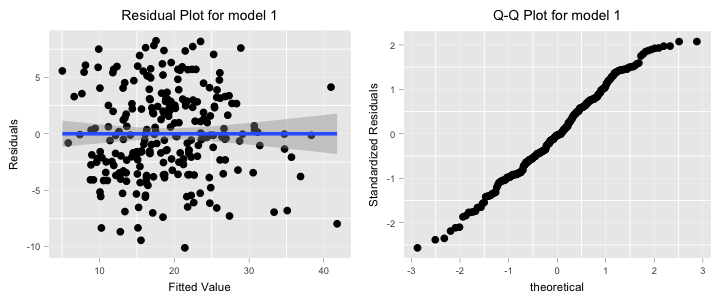

In [43]:
options(repr.plot.width=6, repr.plot.height=2.5, repr.fig.align='center')
res <- m1$residuals
fit <- m1$fitted.values
d <- data.frame(cbind(res, fit))
p1 <- ggplot(d, aes(fit, res)) +
    geom_point() +
    geom_smooth(method = 'lm') + 
    labs(title = 'Residual Plot for model 1', x = 'Fitted Value', y = 'Residuals') +
    theme(text = element_text(size = 7), element_line(size = 0.1), plot.title = element_text(hjust = 0.5))
standres <- data.frame(sample = rstandard(m1))
p2 <- ggplot(standres, aes(sample = sample)) +
    geom_point(stat = "qq") +
    ggtitle('Q-Q Plot for model 1') + 
    ylab("Standardized Residuals") +
    theme(text = element_text(size = 7), element_line(size = 0.1), plot.title = element_text(hjust = 0.5))
grid.arrange(p1, p2, ncol=2)

**Plot interpretation ans corresponding test**
* For Residual Plot, we can see there is no wried pattern and the points are randomly dispersed around the horizontal axis, thus the linear regression model seems to be appropriate for the data.
* For Q-Q plot, we can see the points fall on the 45-degree reference line which indicate standardized residual follows standard normal distribution.

#### 4.1.2 Formal Assumption Test

Apart from diagnostic plot, we also used some other tests to check linear model assumption.

**Normality Assumption**

$H_{0}:$ The population is normally distributed.

In [44]:
shapiro.test(m1$residuals)


	Shapiro-Wilk normality test

data:  m1$residuals
W = 0.98948, p-value = 0.06853


According to p-value which is larger than $0.05$, we can retain $H_{0}$ and say that the error term $\epsilon_i$ is distributed as Normally distributed.

**Multi-collinearity Test**

In [45]:
vif(m1)

WEIGHT  FOREARM  ABDOMEN    WRIST 
7.163865 1.776990 4.840785 2.314290

The variance inflation factor for all variables in $model \ 1$ is smaller than 10, thus the model doesn't have serious multi-collinearity problem.

**Homoscedasticity Test**

$H_{0}:$ The tested model has constant error variance 

In [46]:
ncvTest(m1)

Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.05194751    Df = 1     p = 0.8197085 

From the test result above, p-value is larger than $0.05$ which means we can retain $H_{0}$ and say $model \ 1$ has constant error variance

** linearity test**

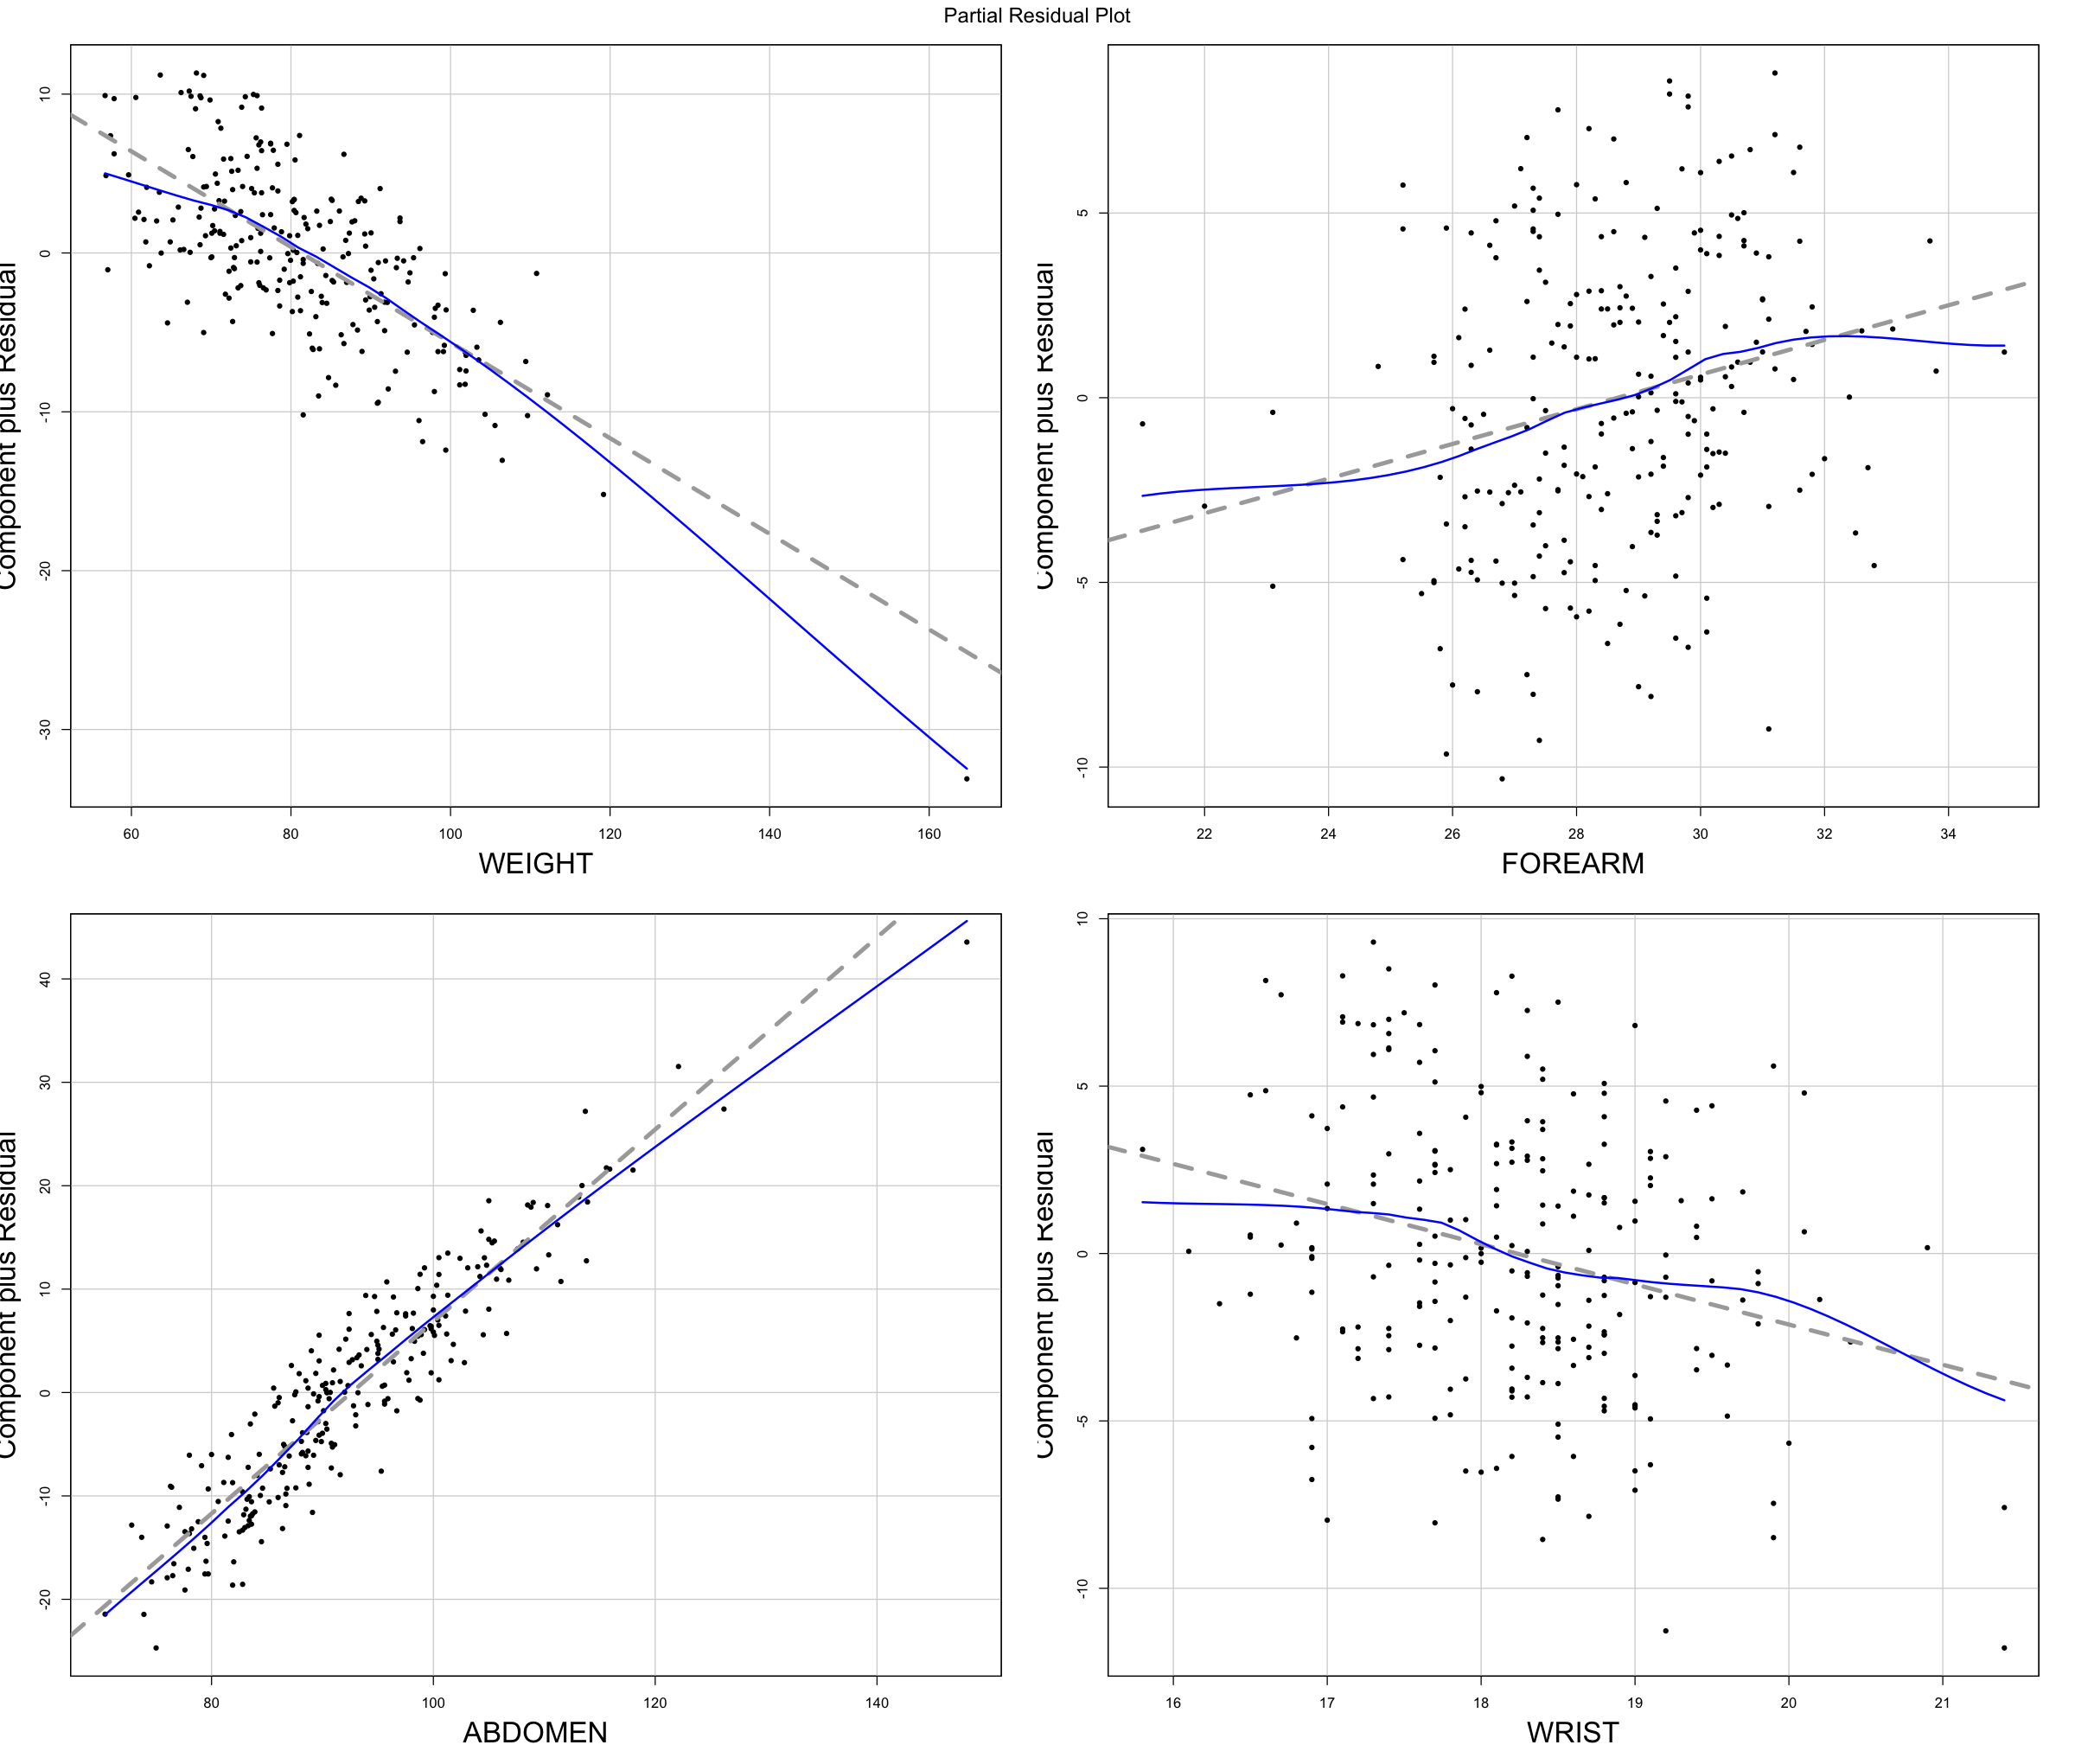

In [87]:
options(repr.plot.width=20, repr.plot.height=17, repr.fig.align='center')
col <- c("#000000", "#009E73", "#e79f00", "#9ad0f3", "#0072B2", "#D55E00", 
    "#CC79A7", "#F0E442")
crPlots(m1, ylab = 'Component plus Residual',main = 'Partial Residual Plot',
            col.lines = c( 'darkgrey','blue'), pch = 20, lwd = 4, cex = 50, grid = TRUE,
            cex.lab = 2, cex.main = 3)

From the partial residual plot above, we can see in figure WEIGHT, the fitted lowess line has a relatively large deviation to the ls line. Thus we suspected linearity assumption may not be satisified.
To improve the model, we did box-cox transformation for variable `WEIGHT` and the new model is like: 

$$ BODYFAT(\%) = 30 - 0.5 WEIGHT (kg) + 0.9 ABDOMEN (cm) + 0.2 FOREARM (cm) - 1.3 WRIST (cm) - 766.5 WEIGHT^{-0.7}$$

Denote as $model \ 3$

We first check its linearty using partial residual plot:


In [68]:
W2 <- WEIGHT^(-0.707070707070708)
m3<- lm(BODYFAT ~ ABDOMEN + WEIGHT + FOREARM + WRIST + W2)

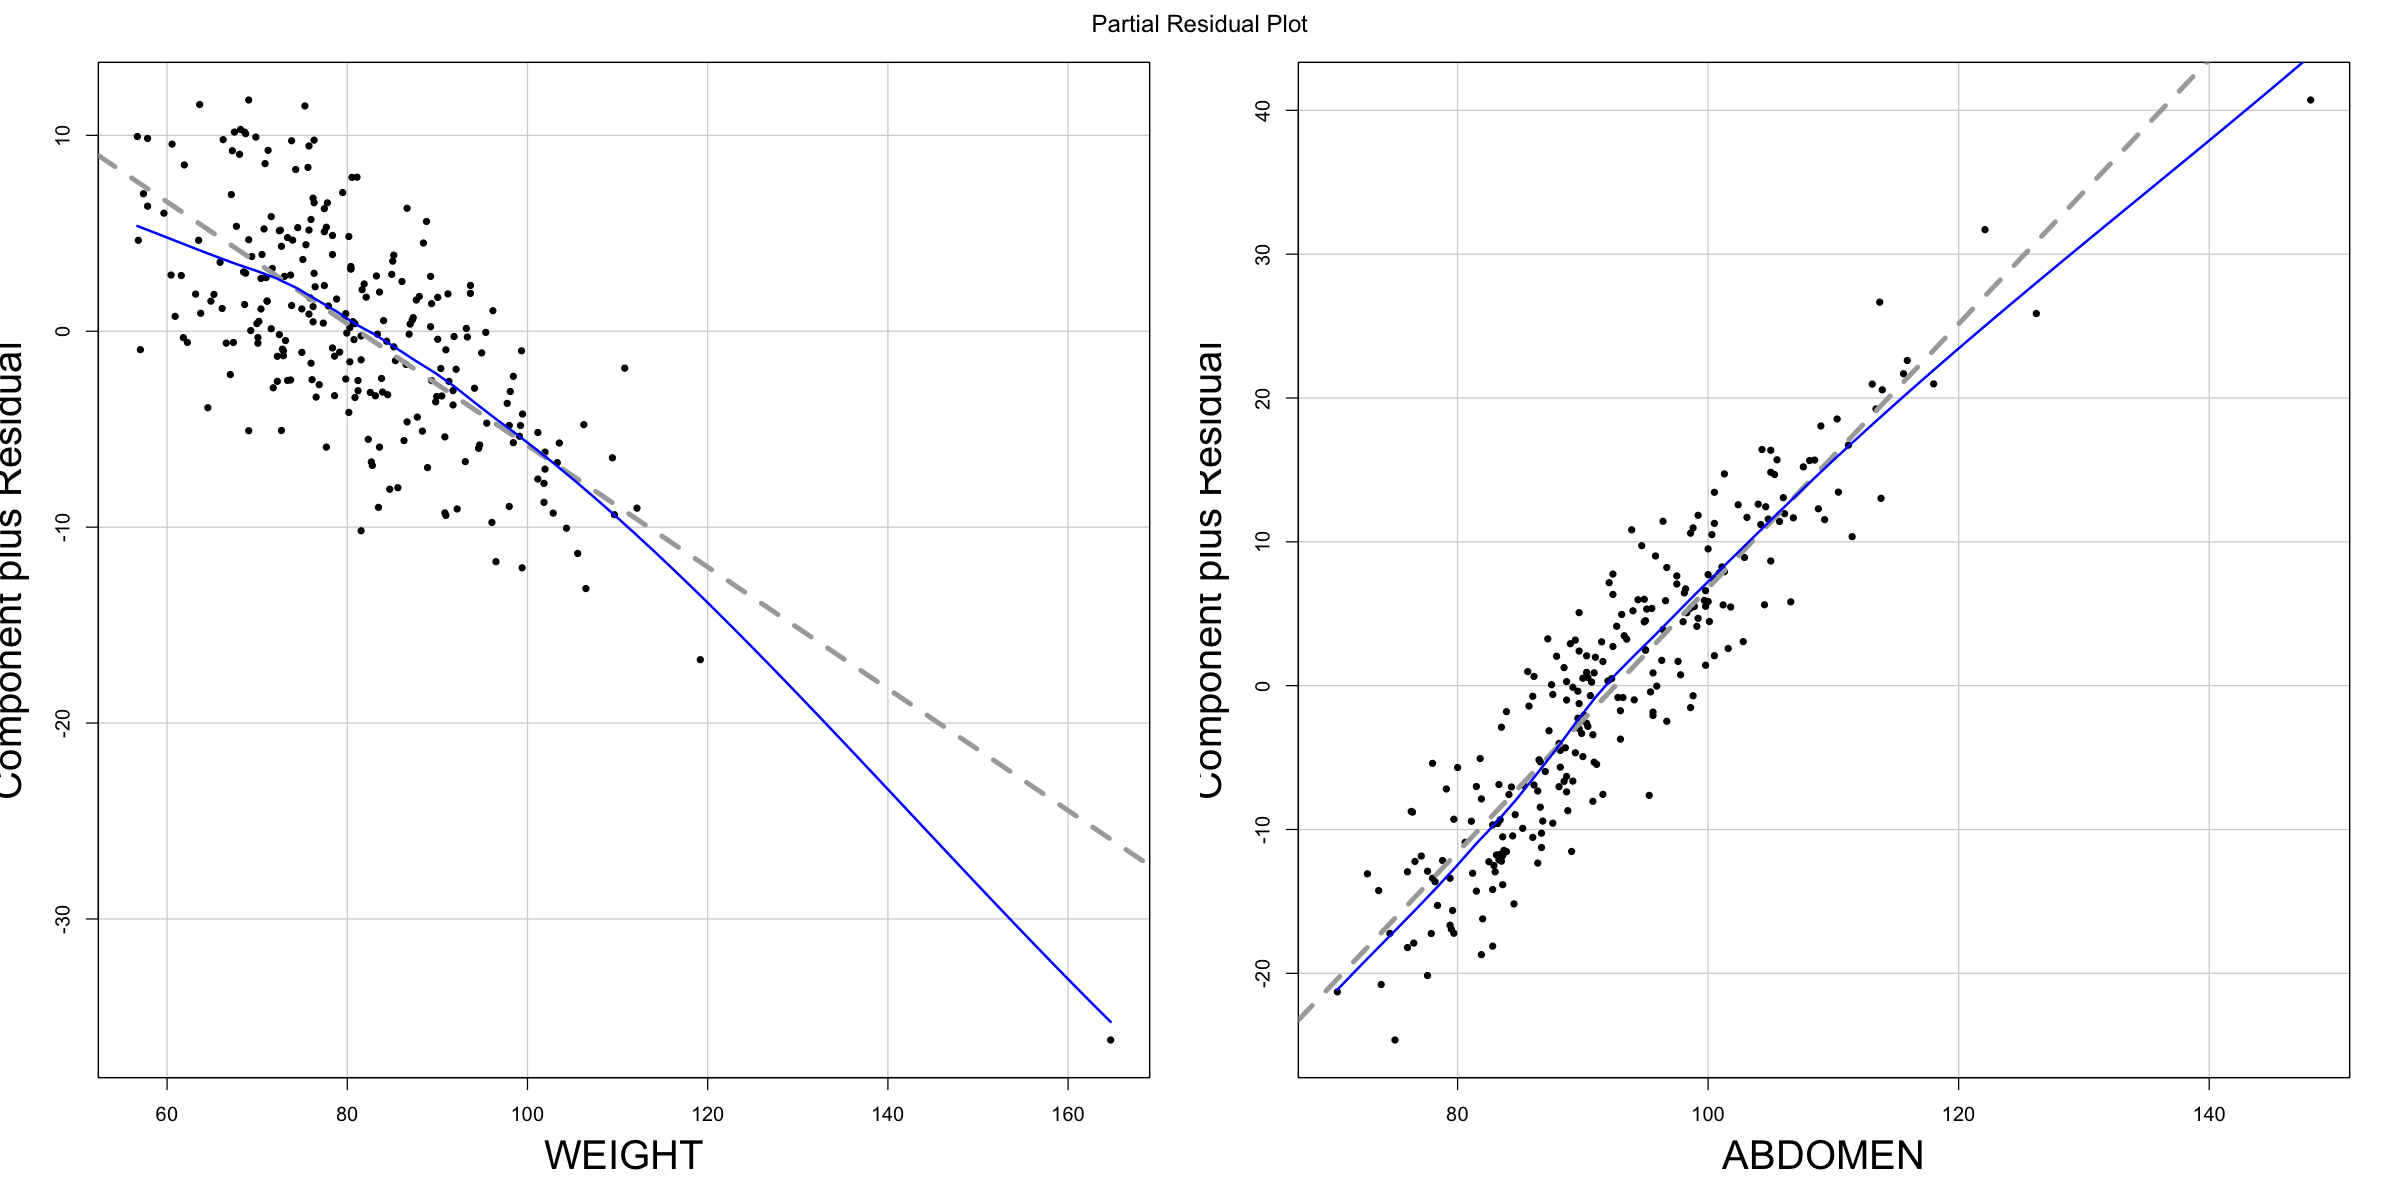

In [79]:
options(repr.plot.width=20, repr.plot.height=10, repr.fig.align='center')
crPlots(m2, ylab = 'Component plus Residual',main = 'Partial Residual Plot',
            col.lines = c( 'darkgrey','blue'), pch = 20, lwd = 4, grid = TRUE,
            cex.lab = 2)

From the plot above, we can conclude linearity assumption is passes. And we further test other assumptions, here are the results:

| Test                   | Null hypothesis                   |p-value  |
| :----------------------| :-------------------------------: | :-----: |
| Normality Test         | residual is normally distributed  |0.193    |
| Homoscedasticity Test  | error's variance is constant      |0.469    | 

In [70]:
ncvTest(m3)

Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.5248911    Df = 1     p = 0.4687627 

All tests are passed, we concluded $model \ 3$ satisfies all necessary assumption for linear model.

### 4.2 Diagnostic for Model 2

We then diagnosed $model \ 2$ using similar procedure. All tests except linearity test were passed. The results are shown below: 

| Test                   | Null hypothesis                   |p-value      |
| :----------------------| :-------------------------------: | :---------: |
| Normality Test         | residual is normally distributed  |0.2689       |
| Homoscedasticity Test  | error's variance is constant      |0.8069476    | 

In [39]:
vif(m2)

WEIGHT  ABDOMEN 
4.684296 4.684296

Since the linearity assumption didn't satisfied. We transformed `HEIGHT` and improved model. Denote new model as $model \ 4$. 

According to partial residual plot, $model \ 4$ satisfied linearity assumption. It also passed all other tests.

In [72]:
m4 <- lm(BODYFAT ~ ABDOMEN + WEIGHT + W2)


Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + W2)

Coefficients:
(Intercept)      ABDOMEN       WEIGHT           W2  
    17.4209       0.9093      -0.5845    -775.3436  


Here is the test results for $model \ 4$:

| Test                   | Null hypothesis                   |p-value      |
| :----------------------| :-------------------------------: | :---------: |
| Normality Test         | residual is normally distributed  |0.3292       |
| Homoscedasticity Test  | error's variance is constant      |0.4086975    | 

In [ ]:
vif(m4)

## Model Comparison

From all of the analysis above, we obtained four models. There adjusted-R square are: 0.7294, 0.7168, 0.7398 and 0.729. Since our main goal for this project is prediction, and these four adjusted-R square are similar enough. Although there exist statistical differenc between four variable model and two variable model, we decided to use $model \ 2$ as our final model. 

$$ BodyFat (\%) = -40.80 - 0.31Weight (kg) + 0.92Abdomen (cm) $$

Here is the models coefficients, all variables are significant.

In [40]:
summary(m2)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-40.7971089,2.40762355,-16.944970,3.757215e-43
WEIGHT,-0.3106853,0.04225617,-7.352424,2.907411e-12
ABDOMEN,0.9184448,0.05223807,17.581906,2.590109e-45


## rules of thumb

**multiply your weight (kg) by $0.3$, add your abdomen (cm) and minus $50$**

**Example Usage:**

For a 80 kg man with abdomen circumference about 90 cm, his predicted body fat % percentage would be around 17%. There is a 95% probability that his body fat is between 16.5% and 17.5%.

Using the simpule of thumb, you get about 16% as the predicted body fat 16%.


## Strengths and Weaknesses

The model is a reasonable model between body fat % and abdomen, weight.

Moreover, the model has the following strengths and advantages:

1. Explanatory variables: reasonable since it's easy to think one’s body fat with his weight and abdomen. Intuitively, if a man has a large abdomen circumference, he tends to be fatter and with larger body fat percentage. Meanwhile, if his is heavier given other body measurements fixed, he is likely to be more muscled. Since fat has smaller density. 

2. Constant effects: reasonable because it is not affected by age or non-body factors. 

3. Normally distributed errors: seems reasonable from the Q-Q plot diagnostic and also the model passed Shapiro-Wilk’s test. 

4. Constant variance: the model passed the score test for non-constant error variance Overall, our model provides a relatively simple way of predict the body fat % purely based on weight, forearm, wrist and abdomen.

5. The units for weight and abdomen are kg and cm, which are under the same system. It will be more convenient to use.

6. The proposed model is quite simple with a good adjust R square value.

Last but not least, there still exists some potential weaknesses or questions.


1. The model doesn't satisfy linearity assumption.

2. The data was only collected for men, and therefore the model is only suitable for men. Does there exist a general formula for both men and women?

# Contribution
Data cleaning: Xinjie Ye, Jianxiong Wang, Yiqiao Zhang, Jia Liu

Model fitting: Xinjie Ye, Jianxiong Wang, Yiqiao Zhang, Jia Liu

Summary: Xinjie Ye, Jianxiong Wang

Slides: Yiqiao Zhang, Jia Liu

# Reference

[1] Body fat percentage, Wikipedia, https://en.wikipedia.org/wiki/Body_fat_percentage

[2] QuickStats: Mean Percentage Body Fat, by Age Group and Sex --- National Health and Nutrition Examination Survey, United States, 1999--2004